## Setup

In [1]:
!pip install rouge

In [2]:
# !pip install nltk==3.5

In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

In [4]:

t = 2

ktory_model = [InceptionV3, VGG16, ResNet50]
MODEL = ktory_model[t]

# Desired image dimensions - 299 for inception
IMAGE_SIZE = (224, 224)
# IMAGE_SIZE = (299, 299)

# Other training parameters
BATCH_SIZE = 105
EPOCHS = 30

In [5]:
!pip install pycocoevalcap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.6 MB/s eta 0:00:00


In [6]:
from pycocoevalcap.cider.cider import Cider

  #  from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu
from nltk.tokenize import word_tokenize
import math
from rouge import Rouge
import nltk
from nltk.translate import meteor_score
# Download the METEOR paraphrase tables
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet_ic')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.


True

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.nist_score import sentence_nist, corpus_nist
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download the dataset


In [10]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [11]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"



# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters

AUTOTUNE = tf.data.AUTOTUNE

In [12]:
!mkdir /content/do_pobrania/

## Preparing the dataset

In [13]:
# NOWE PLIKI PODPISOW ZE SCIEZKAMI - WSZYSTKO I 20

# Read the caption data from the file
with open("Flickr8k.token.txt") as caption_file:
    caption_data = caption_file.readlines()

# Remove the first 20 images from the caption data
usuniete_20_podpisow_ze_sciezkami = caption_data[:100]
# Remove the first 20 images from the caption data
caption_data = caption_data[100:]

# Write the updated caption data to a text file
with open("podpisy_trening_bez_20.txt", "w") as outfile:
    outfile.writelines(caption_data)

# Write the removed captions to a text file
with open("/content/do_pobrania/usuniete_20_podpisy_ze_sciezkami.txt", "w") as outfile:
    outfile.writelines(usuniete_20_podpisow_ze_sciezkami)


In [14]:
# SAME 20 SCIEZEK

# Remove the first 20 images from the caption data
sciezki_do_usunietych_zdjec = [line.split('#')[0] for line in usuniete_20_podpisow_ze_sciezkami]

# Remove duplicate lines
sciezki_do_usunietych_zdjec = list(set(sciezki_do_usunietych_zdjec))

# Remove trailing whitespace and write the removed captions to a text file
with open("/content/do_pobrania/same_sciezki_do_usunietych_zdjec.txt", "w") as outfile:
    outfile.writelines(line.rstrip() + '\n' for line in sciezki_do_usunietych_zdjec)


In [15]:
sciezki_do_usunietych_zdjec[0]

'1020651753_06077ec457.jpg'

In [16]:
len(caption_data)

40360

In [17]:
IMAGES_PATH

'Flicker8k_Dataset'

In [18]:
# USUWANIE 20 OBRAZOW Z FOLDERU Z OBRAZAMI
# TWORZENIE FOLDERU Z 20 OBRAZAMI
import os
import shutil

i=0
initial_file_count = len(os.listdir("/content/Flicker8k_Dataset/"))

# Remove the images
for image_path in sciezki_do_usunietych_zdjec:
    source_path = os.path.join("/content/Flicker8k_Dataset/", image_path)
    target_path = os.path.join("/content/moje_20_zdj/", os.path.basename(image_path))

    # Create the target directory if it doesn't exist
    os.makedirs(os.path.dirname(target_path), exist_ok=True)
    if os.path.exists(source_path):
        # Copy the image to the target directory
        shutil.copy(source_path, target_path)

        # Remove the image from the original directory
        os.remove(source_path)
        i+=1

# Get the final number of files in the directory
final_file_count = len(os.listdir("/content/Flicker8k_Dataset/"))

# Print the number of files before and after the loop
print("Number of files before:", initial_file_count)
print("Number of files after:", final_file_count)
print(i)

# Load the dataset
# captions_mapping, text_data = load_captions_data('/content/updated_caption_data.txt')

# # Split the dataset into training and validation sets
# train_data, valid_data = train_val_split(captions_mapping)
# print("Number of training samples:", len(train_data))
# print("Number of validation samples:", len(valid_data))


Number of files before: 8091
Number of files after: 8071
20


In [19]:

def load_captions_data(filename, folder_z_obrazami = IMAGES_PATH):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(folder_z_obrazami, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("podpisy_trening_bez_20.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping,  train_size = 0.8)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))


Number of training samples:  6098
Number of validation samples:  1525


## Vectorizing the text data



In [20]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


## Building a `tf.data.Dataset` pipeline for training



In [21]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


## Building the model



In [22]:

def get_cnn_model():
    base_model = MODEL(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class Encoder(layers.Layer):
    def __init__(self, cnn_model, **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model

    def call(self, inputs, training=False):
        img_embed = self.cnn_model(inputs)
        return img_embed


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_3 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_4 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.layernorm_4 = layers.LayerNormalization()
        self.layernorm_5 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        attention_output_3 = self.attention_3(
            query=out_2,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_3 = self.layernorm_3(out_2 + attention_output_3)

        attention_output_4 = self.attention_4(
            query=out_3,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_4 = self.layernorm_4(out_3 + attention_output_4)



        ffn_out = self.ffn_layer_1(out_4)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_5(ffn_out + out_4, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        # self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        # encoder_out = self.encoder(img_embed)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, img_embed, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.encoder(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # TUUUU@@@
            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.encoder(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
# encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
encoder = Encoder(cnn_model)  # Create an instance of the Encoder class
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=4)
caption_model = ImageCaptioningModel(
    encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

94765736/94765736 [==============================] - 3s 0us/step


## Model training

In [23]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
59/59 [==============================] - 153s 2s/step - loss: 28.9335 - acc: 0.1388 - val_loss: 21.7587 - val_acc: 0.2830
Epoch 2/30
59/59 [==============================] - 110s 2s/step - loss: 20.2220 - acc: 0.3052 - val_loss: 19.2898 - val_acc: 0.3368
Epoch 3/30
59/59 [==============================] - 104s 2s/step - loss: 18.2379 - acc: 0.3442 - val_loss: 18.1365 - val_acc: 0.3477
Epoch 4/30
59/59 [==============================] - 113s 2s/step - loss: 17.1189 - acc: 0.3638 - val_loss: 17.4430 - val_acc: 0.3586
Epoch 5/30
59/59 [==============================] - 114s 2s/step - loss: 16.2373 - acc: 0.3767 - val_loss: 17.0220 - val_acc: 0.3655
Epoch 6/30
59/59 [==============================] - 106s 2s/step - loss: 15.6265 - acc: 0.3895 - val_loss: 16.6002 - val_acc: 0.3694
Epoch 7/30
59/59 [==============================] - 113s 2s/step - loss: 15.0547 - acc: 0.3993 - val_loss: 16.2853 - val_acc: 0.3789
Epoch 8/30
59/59 [==============================] - 107s 2s/step - lo

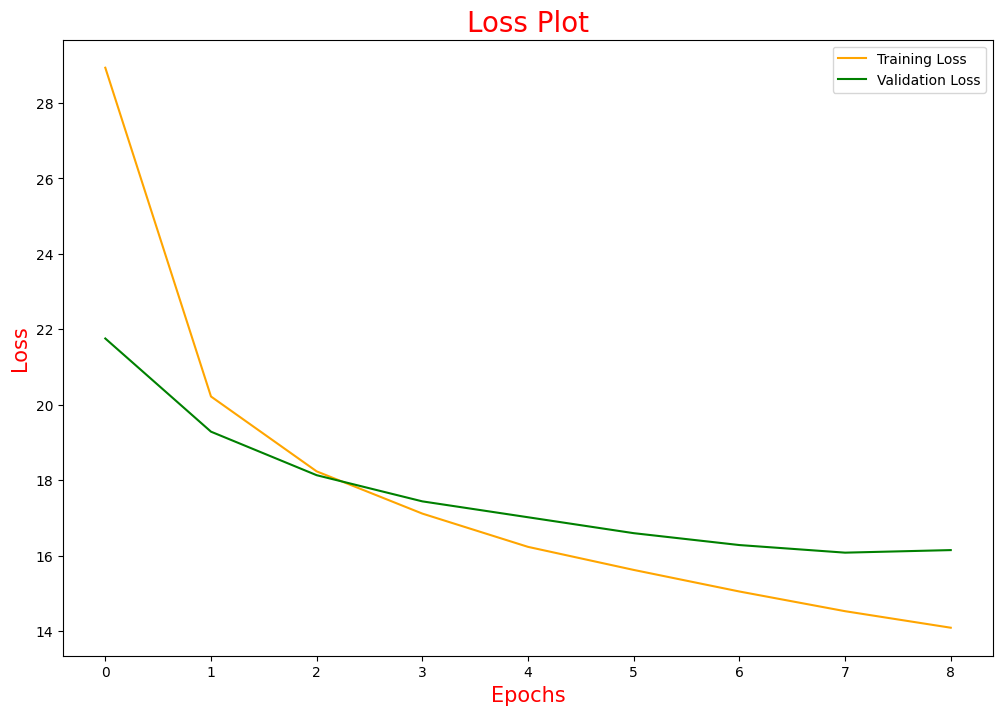

In [24]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8))
plt.plot(history.history['loss'], color='orange', label='Training Loss')
plt.plot(history.history['val_loss'], color='green', label='Validation Loss')
plt.xlabel('Epochs', fontsize=15, color='red')
plt.ylabel('Loss', fontsize=15, color='red')
plt.title('Loss Plot', fontsize=20, color='red')
plt.legend()
plt.show()


## Metryki

In [25]:
def bleu_metric(references, candidate, weights=(0.5, 0.5, 0, 0)) :

    smooth_func = SmoothingFunction().method4  # You can try different smoothing methods
    score = sentence_bleu(references, candidate, weights=weights, smoothing_function=smooth_func)#set your weights

    print(f"BLEU score: {score*100}")


In [26]:
def rouge_metric(references, candidate) :

    rouge = Rouge()
    rouge_scores = []
    for i in range(len(references)):
        ref_scores = rouge.get_scores(references[i], candidate, avg=True)
        rouge_scores.append(ref_scores)

    avg_rouge_scores = {}
    for metric in rouge_scores[0].keys():
        avg_rouge_scores[metric] = {
            'r': sum(score[metric]['r'] for score in rouge_scores) / len(rouge_scores),
            'p': sum(score[metric]['p'] for score in rouge_scores) / len(rouge_scores),
            'f': sum(score[metric]['f'] for score in rouge_scores) / len(rouge_scores)
        }

    print("ROUGE scores:")
    for metric, values in avg_rouge_scores.items():
        print(f"{metric}:")
        print(f"  Recall:    {values['r']:.4f}")
        print(f"  Precision: {values['p']:.4f}")
        print(f"  F1-score:  {values['f']:.4f}")


In [27]:
def meteor_metric(references, candidate) :
    candidate = word_tokenize(candidate)
    score = meteor_score.meteor_score(references, candidate)

    print(f"METEOR score: {score}")


In [28]:
def cider_metric(ref, cand) :
    #n=4
    costam = ["1", "2", "3", "3", "3"]
    references = {1: ref, 2: costam}
    candidate = {1: [cand], 2: [costam[0]]}

    # Create an instance of the Cider class
    cider_scorer = Cider()

    # Compute the CIDEr scores
    scores, scores_per_image = cider_scorer.compute_score(references, candidate)

    # print("Overall CIDEr score:", scores)
    # print("CIDEr score per image:", scores_per_image)
    print("CIDEr score: ", scores_per_image[0])


## Check sample predictions

In [29]:
import re

def apply_regex(input_text):
    # Convert text to lowercase
    input_text = input_text.lower()

    # Define the characters to be stripped
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"

    # Remove "<" and ">" from strip_chars
    strip_chars = strip_chars.replace("<", "").replace(">", "")

    # Create the regex pattern
    pattern = "[" + re.escape(strip_chars) + "]"

    # Apply regex substitution
    output_text = re.sub(pattern, "", input_text)

    return output_text

def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [30]:
def referencje_do_danego_obrazu_w_dobrej_formie(image_path, czy_m=None):

    real_captions = caption_mapping[image_path]

    real_appn = []


    for cap in real_captions:
        cap = apply_regex(filt_text(cap))
        if czy_m is None:
            real_appn.append(cap)
        else:
            cap_tokens = word_tokenize(cap)
            real_appn.append(cap_tokens)



    return real_appn

In [31]:
# generowanie obrazu dla wsyztskich metryk
def obraz_i_wszytskie_podpisy_i_metryki_generator(image_path, decoded_caption):

    test_image = image_path # sciezka do obrazu

    references = referencje_do_danego_obrazu_w_dobrej_formie(image_path)

    candidate = decoded_caption

    print('Prediction Caption:', candidate,'\n')
    print('Real Captions:')
    for caption in references:
        print(caption)
    print('\n')

    bleu_metric(references, candidate, weights=(0.5, 0.5, 0, 0))
    rouge_metric(references, candidate)
    cider_metric(references, candidate)
    references = referencje_do_danego_obrazu_w_dobrej_formie(image_path, 0)
    meteor_metric(references, candidate)




In [32]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1


def generate_caption(image_path):
    # Select a random image from the validation dataset
    sample_img = image_path

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    # img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    # print("Predicted Caption: ", decoded_caption)
    obraz_i_wszytskie_podpisy_i_metryki_generator(image_path, decoded_caption)




In [33]:
IMAGES_PATH="/content/moje_20_zdj/"
captions_file = "/content/do_pobrania/usuniete_20_podpisy_ze_sciezkami.txt"
caption_mapping, _ = load_captions_data(captions_file, IMAGES_PATH)

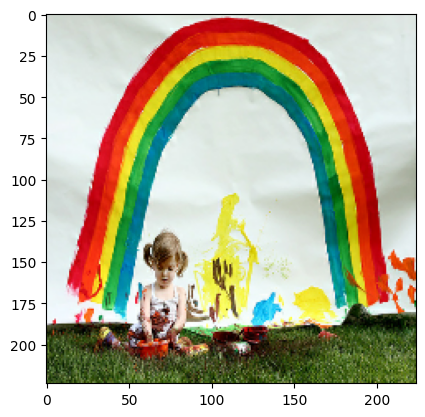

Prediction Caption: a child is standing in a field of green and a small child are standing in a green and playing in a green and 

Real Captions:
a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl 
a little girl is sitting in front of a large painted rainbow 
a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it 
there is a girl with pigtails sitting in front of a rainbow painting 
young girl with pigtails painting outside in the grass 


BLEU score: 61.480522289389484
ROUGE scores:
rouge-1:
  Recall:    0.2667
  Precision: 0.2516
  F1-score:  0.2569
rouge-2:
  Recall:    0.0235
  Precision: 0.0216
  F1-score:  0.0225
rouge-l:
  Recall:    0.2167
  Precision: 0.2091
  F1-score:  0.2111
CIDEr score:  0.34862558378742137
METEOR score: 0.26079963235294124


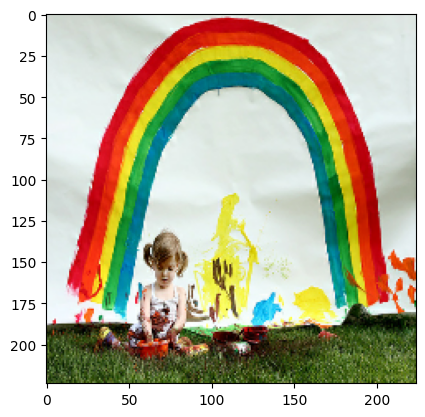

Prediction Caption: a child is standing in a field of green and a small child are standing in a green and playing in a green and 

Real Captions:
a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl 
a little girl is sitting in front of a large painted rainbow 
a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it 
there is a girl with pigtails sitting in front of a rainbow painting 
young girl with pigtails painting outside in the grass 


BLEU score: 61.480522289389484
ROUGE scores:
rouge-1:
  Recall:    0.2667
  Precision: 0.2516
  F1-score:  0.2569
rouge-2:
  Recall:    0.0235
  Precision: 0.0216
  F1-score:  0.0225
rouge-l:
  Recall:    0.2167
  Precision: 0.2091
  F1-score:  0.2111
CIDEr score:  0.34862558378742137
METEOR score: 0.26079963235294124


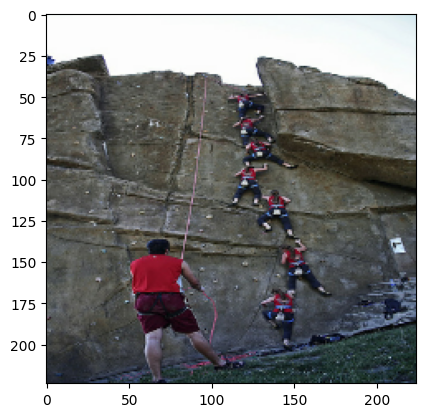

Prediction Caption: a man in a red shirt is climbing a rock wall 

Real Captions:
a collage of one person climbing a cliff 
a group of people are rock climbing on a rock climbing wall 
a group of people climbing a rock while one man belays
seven climbers are ascending a rock face whilst another man stands holding the rope 
several climbers in a row are climbing the rock while the man in red watches and holds the line 


BLEU score: 94.00643223910575
ROUGE scores:
rouge-1:
  Recall:    0.4222
  Precision: 0.3439
  F1-score:  0.3713
rouge-2:
  Recall:    0.1400
  Precision: 0.1262
  F1-score:  0.1295
rouge-l:
  Recall:    0.3333
  Precision: 0.2846
  F1-score:  0.3008
CIDEr score:  1.132199089714097
METEOR score: 0.4054545454545455


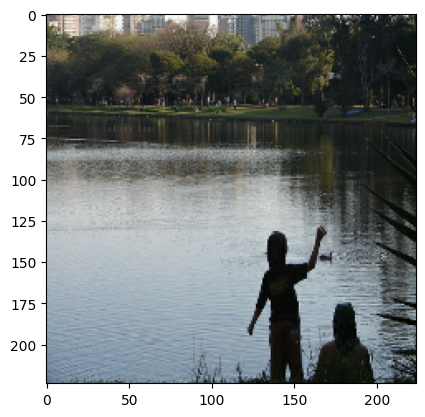

Prediction Caption: a man is standing in water near a lake 

Real Captions:
a child and a woman are at waters edge in a big city 
a large lake with a lone duck swimming in it with several people around the edge of it 
a little boy at a lake watching a duck 
a young boy waves his hand at the duck in the water surrounded by a green park 
two people are at the edge of a lake  facing the water and the city skyline 


BLEU score: 87.70633494407608
ROUGE scores:
rouge-1:
  Recall:    0.3250
  Precision: 0.2164
  F1-score:  0.2543
rouge-2:
  Recall:    0.0500
  Precision: 0.0383
  F1-score:  0.0424
rouge-l:
  Recall:    0.2750
  Precision: 0.1887
  F1-score:  0.2188
CIDEr score:  0.7418574310514106
METEOR score: 0.16702977487291215


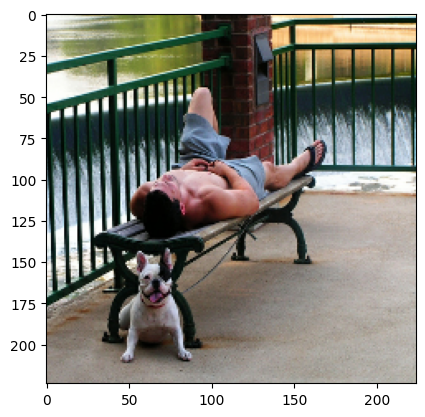

Prediction Caption: a boy is sitting on a bench with a brown dog 

Real Captions:
a man lays on a bench while his dog sits by him 
a man lays on the bench to which a white dog is also tied 
a man sleeping on a bench outside with a white and black dog sitting next to him 
a shirtless man lies on a park bench with his dog 
man laying on bench holding leash of dog sitting on ground


BLEU score: 83.73233595101728
ROUGE scores:
rouge-1:
  Recall:    0.5333
  Precision: 0.4097
  F1-score:  0.4604
rouge-2:
  Recall:    0.1600
  Precision: 0.1339
  F1-score:  0.1442
rouge-l:
  Recall:    0.4667
  Precision: 0.3609
  F1-score:  0.4045
CIDEr score:  1.4837668152736527
METEOR score: 0.42825838414634143


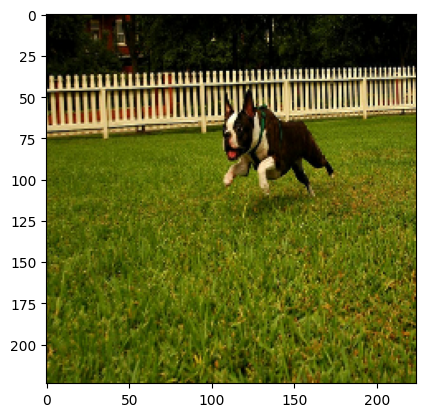

Prediction Caption: a dog is running through a grassy field 

Real Captions:
a black and white dog is running in a grassy garden surrounded by a white fence 
a black and white dog is running through the grass 
a boston terrier is running in the grass 
a boston terrier is running on lush green grass in front of a white fence 
a dog runs on the green grass near a wooden fence 


BLEU score: 91.17393771649036
ROUGE scores:
rouge-1:
  Recall:    0.5143
  Precision: 0.3348
  F1-score:  0.4018
rouge-2:
  Recall:    0.2571
  Precision: 0.1695
  F1-score:  0.2007
rouge-l:
  Recall:    0.5143
  Precision: 0.3348
  F1-score:  0.4018
CIDEr score:  1.4744891824592918
METEOR score: 0.49387755102040815


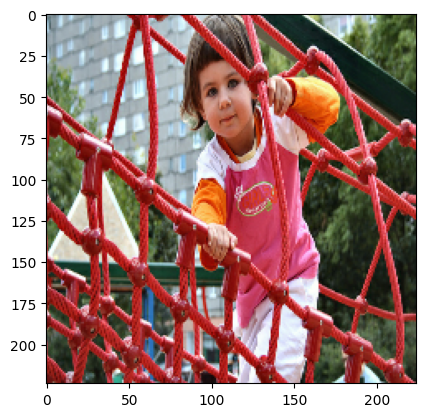

Prediction Caption: a boy in a red shirt is playing a game of water 

Real Captions:
a child playing on a rope net 
a little girl climbing on red roping 
a little girl in pink climbs a rope bridge at the park 
a small child grips onto the red ropes at the playground 
the small child climbs on a red ropes on a playground 


BLEU score: 64.67160547545289
ROUGE scores:
rouge-1:
  Recall:    0.2000
  Precision: 0.2446
  F1-score:  0.2173
rouge-2:
  Recall:    0.0182
  Precision: 0.0222
  F1-score:  0.0200
rouge-l:
  Recall:    0.2000
  Precision: 0.2446
  F1-score:  0.2173
CIDEr score:  0.6166734258852196
METEOR score: 0.23023023023023023


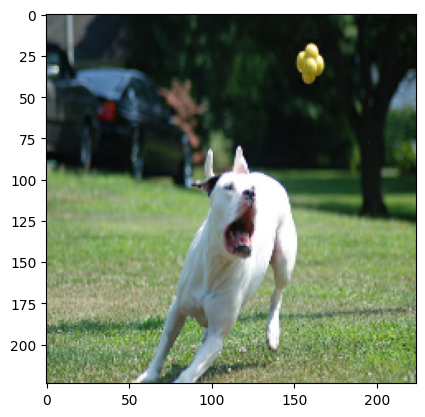

Prediction Caption: a white dog is running through a field 

Real Captions:
a dog prepares to catch a thrown object in a field with nearby cars 
a white dog is about to catch a yellow ball in its mouth 
a white dog is about to catch a yellow dog toy 
a white dog is ready to catch a yellow ball flying through the air 
a white dog running after a yellow ball


BLEU score: 97.40274534203012
ROUGE scores:
rouge-1:
  Recall:    0.5714
  Precision: 0.3968
  F1-score:  0.4617
rouge-2:
  Recall:    0.3429
  Precision: 0.2287
  F1-score:  0.2709
rouge-l:
  Recall:    0.5429
  Precision: 0.3814
  F1-score:  0.4417
CIDEr score:  2.2699253237648325
METEOR score: 0.5575


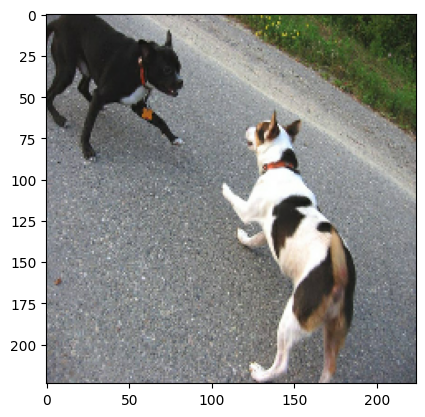

Prediction Caption: a black and white dog is running on a dirt road 

Real Captions:
a black dog and a spotted dog are fighting
a black dog and a tricolored dog playing with each other on the road 
a black dog and a white dog with brown spots are staring at each other in the street 
two dogs of different breeds looking at each other on the road 
two dogs on pavement moving toward each other 


BLEU score: 88.93448825253371
ROUGE scores:
rouge-1:
  Recall:    0.3600
  Precision: 0.3351
  F1-score:  0.3387
rouge-2:
  Recall:    0.0800
  Precision: 0.0639
  F1-score:  0.0692
rouge-l:
  Recall:    0.3400
  Precision: 0.3065
  F1-score:  0.3152
CIDEr score:  0.966891418437922
METEOR score: 0.4043478260869566


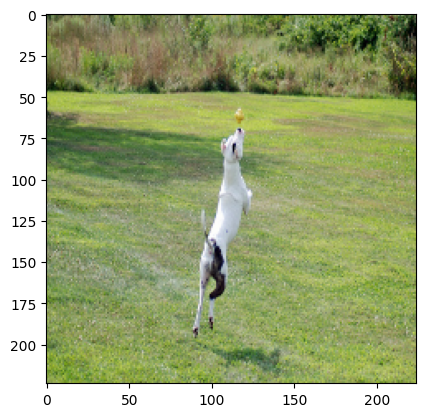

Prediction Caption: a white dog is running on a grassy field 

Real Captions:
a black and white dog jumping in the air to get a toy 
a black and white dog jumps up towards a yellow toy 
a dog leaps to catch a ball in a field 
a white dog is trying to catch a ball in midair over a grassy field 
the white dog is playing in a green field with a yellow toy 


BLEU score: 90.82951062292474
ROUGE scores:
rouge-1:
  Recall:    0.5000
  Precision: 0.3606
  F1-score:  0.4160
rouge-2:
  Recall:    0.2250
  Precision: 0.1414
  F1-score:  0.1731
rouge-l:
  Recall:    0.5000
  Precision: 0.3606
  F1-score:  0.4160
CIDEr score:  1.6860030005943818
METEOR score: 0.5037252996436669


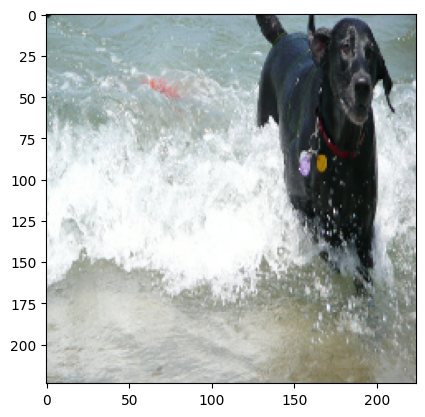

Prediction Caption: a black dog is running through the water 

Real Captions:
a black dog running in the surf 
a black lab with tags frolicks in the water 
a dog splashes in the water
the black dog runs through the water 
this is a black dog splashing in the water 


BLEU score: 98.74208829065749
ROUGE scores:
rouge-1:
  Recall:    0.6000
  Precision: 0.6651
  F1-score:  0.6258
rouge-2:
  Recall:    0.3143
  Precision: 0.3317
  F1-score:  0.3205
rouge-l:
  Recall:    0.5750
  Precision: 0.6429
  F1-score:  0.6022
CIDEr score:  2.5783466245653788
METEOR score: 0.8294209702660407


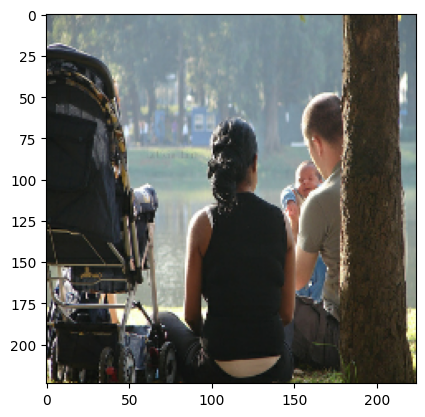

Prediction Caption: a man is standing in the snow 

Real Captions:
a couple and an infant  being held by the male  sitting next to a pond with a near by stroller 
a couple sit on the grass with a baby and stroller 
a couple with their newborn baby sitting under a tree facing a lake 
a man and woman care for an infant along the side of a body of water 
couple with a baby sit outdoors next to their stroller 


BLEU score: 40.557002760173674
ROUGE scores:
rouge-1:
  Recall:    0.2571
  Precision: 0.1446
  F1-score:  0.1833
rouge-2:
  Recall:    0.0333
  Precision: 0.0133
  F1-score:  0.0190
rouge-l:
  Recall:    0.2571
  Precision: 0.1446
  F1-score:  0.1833
CIDEr score:  0.3431877599916086
METEOR score: 0.09933774834437087


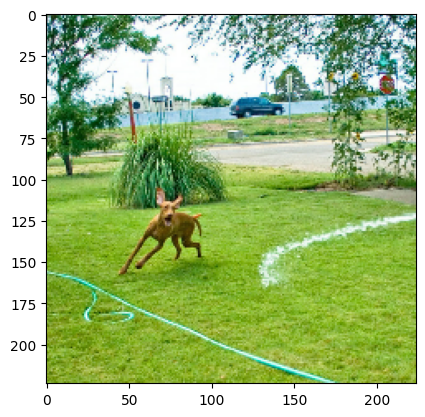

Prediction Caption: a dog is jumping over a fence 

Real Captions:
a brown dog chases the water from a sprinkler on a lawn 
a brown dog plays with the hose 
a brown dog running on a lawn near a garden hose
a dog is playing with a hose 
large brown dog running away from the sprinkler in the grass 


BLEU score: 77.36421443326913
ROUGE scores:
rouge-1:
  Recall:    0.3333
  Precision: 0.2616
  F1-score:  0.2899
rouge-2:
  Recall:    0.0667
  Precision: 0.0667
  F1-score:  0.0667
rouge-l:
  Recall:    0.3333
  Precision: 0.2616
  F1-score:  0.2899
CIDEr score:  1.183895857265716
METEOR score: 0.5357142857142857


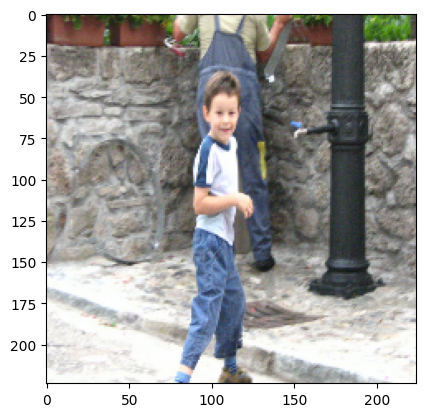

Prediction Caption: a boy in a blue shirt is standing in the snow 

Real Captions:
a boy smiles in front of a stony wall in a city 
a little boy is standing on the street while a man in overalls is working on a stone wall 
a young boy runs aross the street 
a young child is walking on a stone paved street with a metal pole and a man behind him 
smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him 


BLEU score: 90.30517210693874
ROUGE scores:
rouge-1:
  Recall:    0.4000
  Precision: 0.3044
  F1-score:  0.3352
rouge-2:
  Recall:    0.0800
  Precision: 0.0586
  F1-score:  0.0667
rouge-l:
  Recall:    0.3556
  Precision: 0.2793
  F1-score:  0.3032
CIDEr score:  0.8546461916679869
METEOR score: 0.2100840336134454


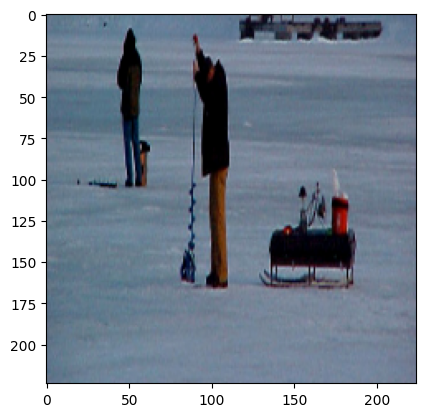

Prediction Caption: a man is walking on a beach 

Real Captions:
a man drilling a hole in the ice 
a man is drilling through the frozen ice of a pond 
a person in the snow drilling a hole in the ice 
a person standing on a frozen lake 
two men are ice fishing 


BLEU score: 75.48513560963971
ROUGE scores:
rouge-1:
  Recall:    0.2667
  Precision: 0.2088
  F1-score:  0.2318
rouge-2:
  Recall:    0.1333
  Precision: 0.1019
  F1-score:  0.1141
rouge-l:
  Recall:    0.2667
  Precision: 0.2088
  F1-score:  0.2318
CIDEr score:  1.2117013944843709
METEOR score: 0.3650793650793651


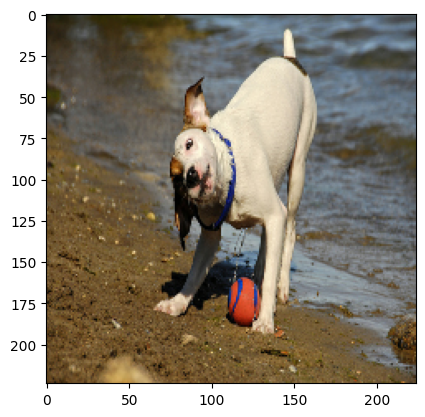

Prediction Caption: a dog and a small dog are playing with a ball in the sand 

Real Captions:
a dog shakes its head near the shore  a red ball next to it 
a white dog shakes on the edge of a beach with an orange ball 
dog with orange ball at feet  stands on shore shaking off water
white dog playing with a red ball on the shore near the water 
white dog with brown ears standing near water with head turned to one side 


BLEU score: 77.53620746836359
ROUGE scores:
rouge-1:
  Recall:    0.3636
  Precision: 0.3192
  F1-score:  0.3399
rouge-2:
  Recall:    0.0462
  Precision: 0.0487
  F1-score:  0.0474
rouge-l:
  Recall:    0.3273
  Precision: 0.2885
  F1-score:  0.3065
CIDEr score:  0.9173829421440374
METEOR score: 0.3901611535199322


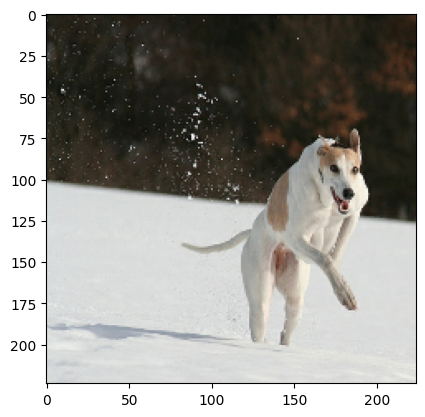

Prediction Caption: a white dog is running through the snow 

Real Captions:
a brown and white dog is running through the snow 
a dog is running in the snow
a dog running through snow 
a white and brown dog is running through a snow covered field 
the white and brown dog is running over the surface of the snow 


BLEU score: 100.0
ROUGE scores:
rouge-1:
  Recall:    0.8000
  Precision: 0.7678
  F1-score:  0.7653
rouge-2:
  Recall:    0.4857
  Precision: 0.4061
  F1-score:  0.4307
rouge-l:
  Recall:    0.8000
  Precision: 0.7678
  F1-score:  0.7653
CIDEr score:  3.6242241495998515
METEOR score: 0.8099489795918368


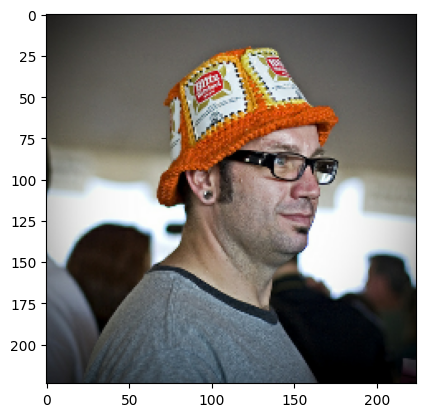

Prediction Caption: a man wearing a red hat and black hat is wearing a red hat 

Real Captions:
a man in an orange hat starring at something 
a man wears an orange hat and glasses 
a man with gauges and glasses is wearing a blitz hat 
a man with glasses is wearing a beer can crocheted hat 
the man with pierced ears is wearing glasses and an orange hat 


BLEU score: 78.32178030674113
ROUGE scores:
rouge-1:
  Recall:    0.5750
  Precision: 0.4700
  F1-score:  0.5150
rouge-2:
  Recall:    0.2000
  Precision: 0.2203
  F1-score:  0.2083
rouge-l:
  Recall:    0.5500
  Precision: 0.4533
  F1-score:  0.4950
CIDEr score:  1.0268694822944728
METEOR score: 0.5065920173379086


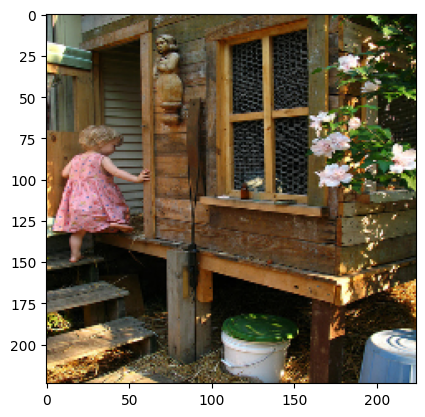

Prediction Caption: a little girl in a pink dress is sitting on a bench 

Real Captions:
a child in a pink dress is climbing up a set of stairs in an entry way 
a girl going into a wooden building 
a little girl climbing into a wooden playhouse 
a little girl climbing the stairs to her playhouse 
a little girl in a pink dress going into a wooden cabin 


BLEU score: 92.73618495495704
ROUGE scores:
rouge-1:
  Recall:    0.3800
  Precision: 0.4105
  F1-score:  0.3871
rouge-2:
  Recall:    0.2545
  Precision: 0.2662
  F1-score:  0.2549
rouge-l:
  Recall:    0.3800
  Precision: 0.4105
  F1-score:  0.3871
CIDEr score:  2.33465732304242
METEOR score: 0.6614583333333333


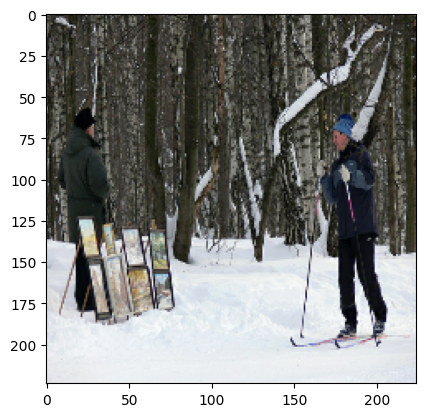

Prediction Caption: a man is walking on a snowy hill 

Real Captions:
a man in a hat is displaying pictures next to a skier in a blue hat 
a man skis past another man displaying paintings in the snow 
a person wearing skis looking at framed pictures set up in the snow 
a skier looks at framed pictures in the snow next to trees 
man on skis looking at artwork for sale in the snow


BLEU score: 47.82646511433754
ROUGE scores:
rouge-1:
  Recall:    0.2571
  Precision: 0.1630
  F1-score:  0.1992
rouge-2:
  Recall:    0.0571
  Precision: 0.0343
  F1-score:  0.0426
rouge-l:
  Recall:    0.2571
  Precision: 0.1630
  F1-score:  0.1992
CIDEr score:  0.45427195450205826
METEOR score: 0.13157894736842105


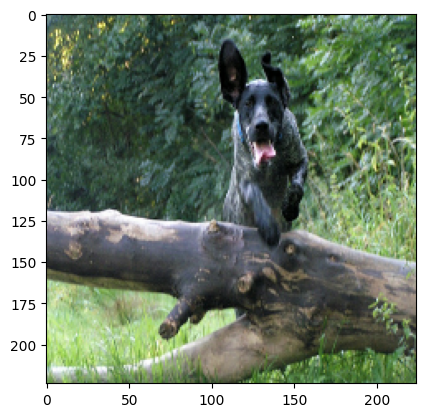

Prediction Caption: a black dog is jumping over a tree 

Real Captions:
a black dog leaps over a log 
a grey dog is leaping over a fallen tree 
a large black dog leaps a fallen log 
a mottled black and grey dog in a blue collar jumping over a fallen tree 
the black dog jumped the tree stump 


BLEU score: 94.28731438548749
ROUGE scores:
rouge-1:
  Recall:    0.6000
  Precision: 0.5364
  F1-score:  0.5544
rouge-2:
  Recall:    0.2571
  Precision: 0.2405
  F1-score:  0.2431
rouge-l:
  Recall:    0.6000
  Precision: 0.5364
  F1-score:  0.5544
CIDEr score:  2.065481425082598
METEOR score: 0.8294209702660407


In [34]:
import os

# Directory containing the images
image_directory = IMAGES_PATH

# Get a list of all the image file names in the directory
image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

# Create a list to hold the image paths
image_paths = [os.path.join(image_directory, f) for f in image_files]


generate_caption(image_paths[0])

# Call the function with each image path in the list
for i in range(len(image_paths)):
    generate_caption(image_paths[i])